# Modelling the UK's Long-term Gas Demand
This notebook contains the code developed as part of my personal project to develop a forecasting model for the UK's natural gas demand using Prophet.

Historical data will be taken from a quarterly basis, and will be used to forecast for the long-term, meaning 12-quarters or 3 years in advance. Unfortunately, no data was available on a monthly basis, and if I took annual data, the number of datapoints would likely be insufficient for a proper analysis.  

This notebook is broken down into 4 sections:
1. Data Processing
2. Data Analysis
3. Modelling
4. Results and Next Steps

## 0. Install Packages

In [52]:
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

## 1. Data Processing
For simplicity of this project, I have compiled and pre-uploaded all data that is needed for this analysis into a csv file. All data was sourced from GOV.UK.

The data obtained includes:
- UK gas consumption data split by sector/use case
- UK weather data
- UK domestic and industrial gas prices

### Read and Inspect data

In [53]:
# Read CSV file
df = pd.read_csv('data.csv')

# Inspect data
display(df.shape)
display(df.dtypes)
display(df.isnull().any())
display(df.head(1))

(96, 18)

date                       object
electricity_generation    float64
domestic                  float64
industrial                float64
services                  float64
producer_own_use          float64
operator_own_use          float64
lng_own_use               float64
storage_own_use           float64
others                    float64
total_demand              float64
rainfall                  float64
sunhours                  float64
windspeed                 float64
temperature               float64
heating_degree_days       float64
domestic_price            float64
industrial_price          float64
dtype: object

date                      False
electricity_generation    False
domestic                  False
industrial                False
services                  False
producer_own_use          False
operator_own_use          False
lng_own_use               False
storage_own_use           False
others                    False
total_demand              False
rainfall                  False
sunhours                  False
windspeed                 False
temperature               False
heating_degree_days       False
domestic_price            False
industrial_price          False
dtype: bool

,date,electricity_generation,domestic,industrial,services,producer_own_use,operator_own_use,lng_own_use,storage_own_use,others,total_demand,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price
0,Q1 2001,82019.0,154586.0,61949.0,37626.0,20415.0,2248.0,0.0,0.0,15383.0,374226.0,249.248935,2.832804,8.794621,4.714601,8.535148,50.659417,63.146926


### Convert date to datetime format

In [54]:
df['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df['date']])
df.head(1)

C:\Users\benja\AppData\Local\Temp\ipykernel_12252\404672300.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df['date']])


,date,electricity_generation,domestic,industrial,services,producer_own_use,operator_own_use,lng_own_use,storage_own_use,others,total_demand,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price
0,2001-01-01,82019.0,154586.0,61949.0,37626.0,20415.0,2248.0,0.0,0.0,15383.0,374226.0,249.248935,2.832804,8.794621,4.714601,8.535148,50.659417,63.146926


## 2. Data Analysis

### UK Total Gas Consumption (From 2001) 


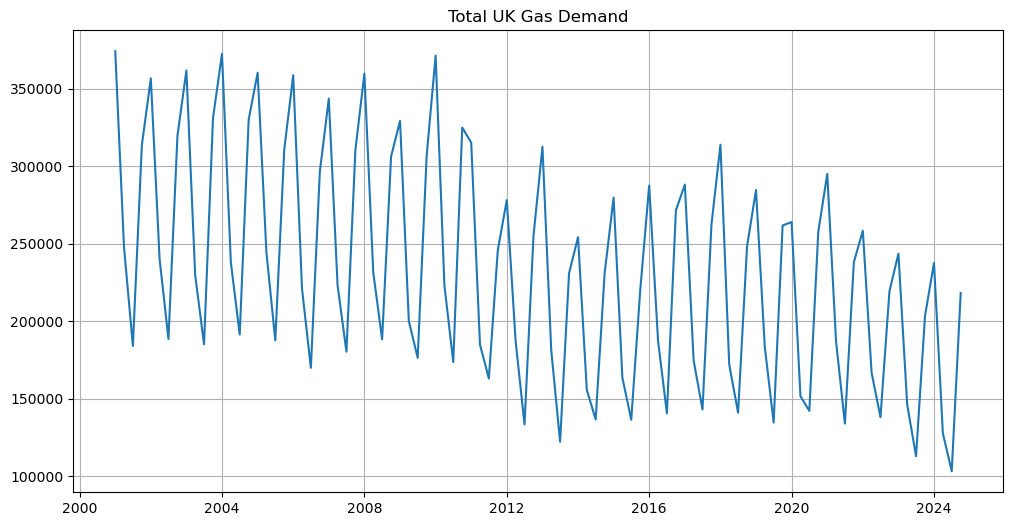

In [55]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df['date'], df['total_demand'])
ax.set_title('Total UK Gas Demand')
ax.grid(True)

Let's use statsmodels decomposition tool to explore further

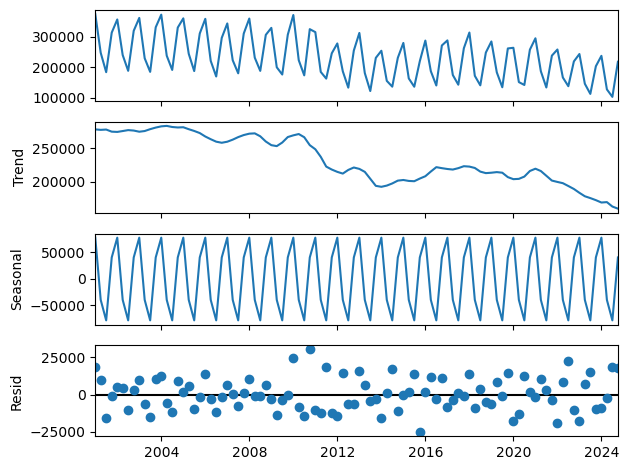

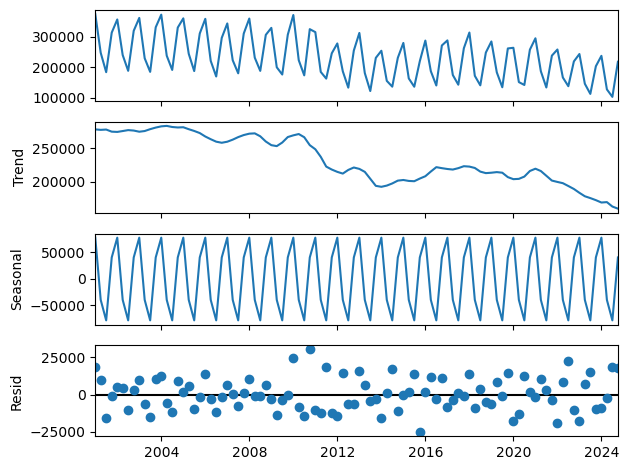

In [56]:
df_breakdown = df[['date','total_demand']]
df_breakdown.set_index('date', inplace=True)

seasonal_breakdown = seasonal_decompose(df_breakdown, model='additive', extrapolate_trend='freq')
seasonal_breakdown.plot()



Overall, the data displays a downward trend with annual seasonal cycles, reflecting gas demand cyclicality due to annual weather variations. Let's break down the total demand by sector to learn more. 

### UK Gas Consumption by Sector
The UK's gas consumption data is split in very fine detail. A very quick look at the data shows that domestic consumption and electricity generation consumption by far outweights the other columns.

To simplify, I will combine all consumption columns into a non-domestic sector. This leaves us with 3 main sectors: 
- Domestic: Gas consumed purely by households
- Non-Domestic: Gas consumed under the industrial sector as well as other non-domestic sectors(commercial,services,energy)
- Electricity Generation: Gas consumed for primary electricity generation

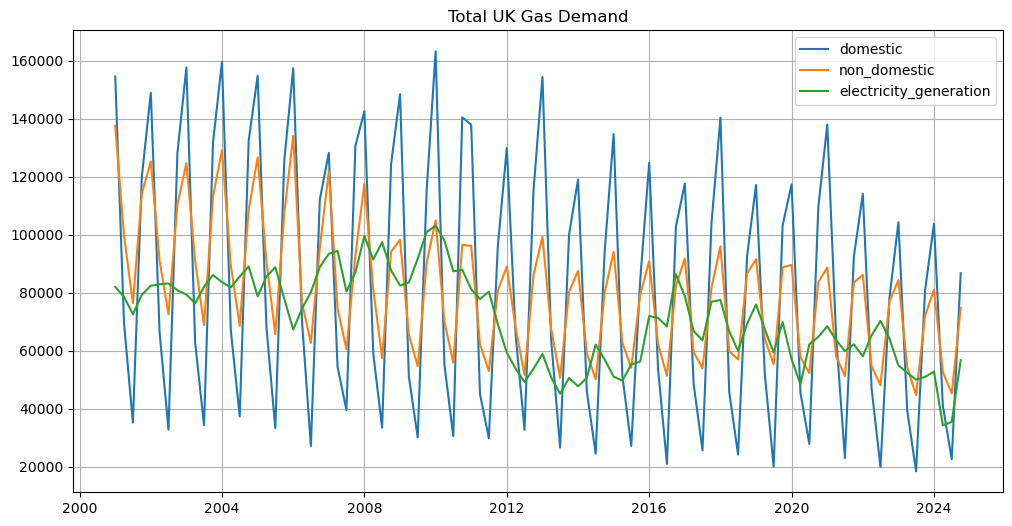

In [57]:
df['non_domestic'] = df['industrial'] + df['lng_own_use'] + df['operator_own_use'] + df['others'] + df['producer_own_use'] + df['storage_own_use'] +df['services']
fig, ax = plt.subplots(figsize=(12,6))
for i in ['domestic','non_domestic','electricity_generation']:
    ax.plot(df['date'], df[i], label=i)
ax.legend()
ax.set_title('Total UK Gas Demand')
ax.grid(True)


Overall, seasonal cycles are more evident within the domestic and non-domestic sectors, and the mean does not vary significantly. The peaks and troughs of demand are more prominent for the domestic sector.

The consumption for electricity generation displays less seasonality, and its mean changes significantly over time. There is a period starting from approximately 2010 where gas demand for electricity generation drops significantly. This is likely due to the increase in coal-powered stations which reduces the demand of gas needed for electricity generation.

The demand for gas under each sector is influenced by different factors, and as such the demand will be modelled separately. 

### Analysis on External Variables
I've also compiled data on external variables that are likely to influence gas demand, e.g. gas prices and the weather.

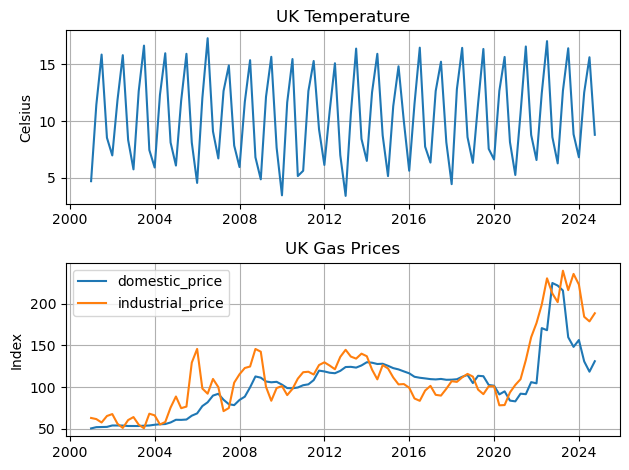

In [58]:
fig, ax = plt.subplots(2,1)
ax[0].plot(df['date'], df['temperature'])
for i in ['domestic_price','industrial_price']:
    ax[1].plot(df['date'], df[i], label=i)
ax[0].set_title('UK Temperature')
ax[1].set_title('UK Gas Prices')
ax[0].set_ylabel('Celsius')
ax[1].set_ylabel('Index')
ax[0].grid(True)
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()

Temperature data displays significant annual cyclicality.
Domestic gas prices and industrial gas prices generally follow the same trend, though industrial prices are more volatile. Gas prices saw a significant spike in 2022 as a result of the Russia-Ukraine war leading to the energy crisis.

## 3. Modelling
### Setting up the Dataframe for Modelling
The last 8 quarters (last 2 years) will be used as the test set. The training/test set will be split 80/20.


In [59]:
# Rename date column to ds
df = df.rename(columns={'date':'ds'})

# Create a function to split df into training set and test set
def split_train_test_set(df, training_start="%Y-%m-%d", test_start="%Y-%m-%d"):
    df_train = df[(df['ds'] >= pd.Timestamp(training_start)) & (df['ds'] < pd.Timestamp(test_start))]
    df_test = df[df['ds'] >= pd.Timestamp(test_start)]
    return df_train, df_test

# Create a function to forecast accuracy of predicted set vs test set
def forecast_accuracy(test_set, forecast_set):
    y_true = test_set['y'].values
    y_forecast = forecast_set['yhat'][-len(test_set):].values

    rmse = np.sqrt(mean_squared_error(y_true, y_forecast))
    mape = mean_absolute_percentage_error(y_true, y_forecast)

    print('RMSE: %.2f' %rmse)
    print('MAPE: %.2f' % mape)

### Modelling Domestic Gas Demand
In a domestic context, gas demand is used primarily for space heating. This means that gas demand are likely to be primarily influenced by external factors like temperature. The colder it is, the more gas that is demanded to heat up domestic homes. Hence, the UK's quarterly temperature data is used as an external regressor.

Additionally, domestic gas prices are also likely to play a small influence on gas demand. 

In [60]:
df = df.rename(columns={'domestic':'y'})

#Scale all external regressors
scaler = StandardScaler()
df[['domestic_price_scaled','temperature_scaled']] = scaler.fit_transform(df[['domestic_price','temperature']])


#Split training set/ test set
df_train, df_test = split_train_test_set(df, '2015-01-01', '2023-01-01')

#Setup model
model = Prophet(
    growth='linear',
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,    #default value
    seasonality_prior_scale=10      #default value
    )
model.add_regressor('temperature_scaled', mode='multiplicative')
model.add_regressor('domestic_price_scaled', mode='multiplicative')

#Fit model to training data
model.fit(df_train)


23:03:32 - cmdstanpy - INFO - Chain [1] start processing
23:03:32 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
df_future = model.make_future_dataframe(periods=len(df_test), freq='QS')
df_future = pd.merge(df_future, df, on='ds')
df_future.tail(5)

,ds,electricity_generation,y,industrial,services,producer_own_use,operator_own_use,lng_own_use,storage_own_use,others,...,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price,non_domestic,domestic_price_scaled,temperature_scaled
35,2023-10-01,50966.25,80708.44,23697.44,27820.90,9366.37,252.56,688.56,0.0,10159.99,...,458.254277,2.105616,9.068274,8.847127,6.711361,148.247093,235.610007,71985.82,1.290168,-0.399788
36,2024-01-01,52777.13,103849.07,26503.32,32270.62,9988.75,263.18,698.55,0.0,11323.54,...,405.990154,2.433354,9.382006,6.818524,8.681476,156.467156,222.860382,81047.96,1.522690,-0.911014
37,2024-04-01,34257.64,40982.33,18120.07,15701.14,9690.28,203.92,221.01,0.0,8672.48,...,254.473992,5.612069,7.989517,12.513213,3.176164,130.877542,184.296719,52608.90,0.798833,0.524097
38,2024-07-01,35454.91,22601.38,16002.17,12254.64,9257.12,220.03,144.81,0.0,7394.01,...,334.713264,5.312244,7.850166,15.614907,0.925958,118.535679,178.765668,45272.78,0.449717,1.305750
39,2024-10-01,56720.48,86749.49,23715.00,29166.51,10678.22,228.58,602.95,0.0,10417.74,...,391.304525,1.944740,8.565454,8.793698,6.706302,131.077109,188.494133,74809.00,0.804478,-0.413253


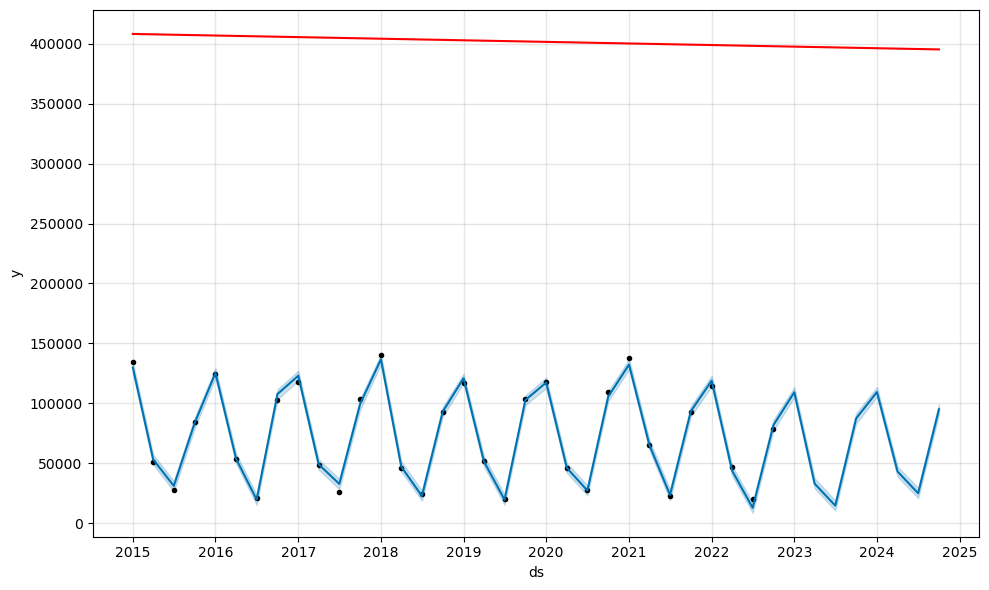

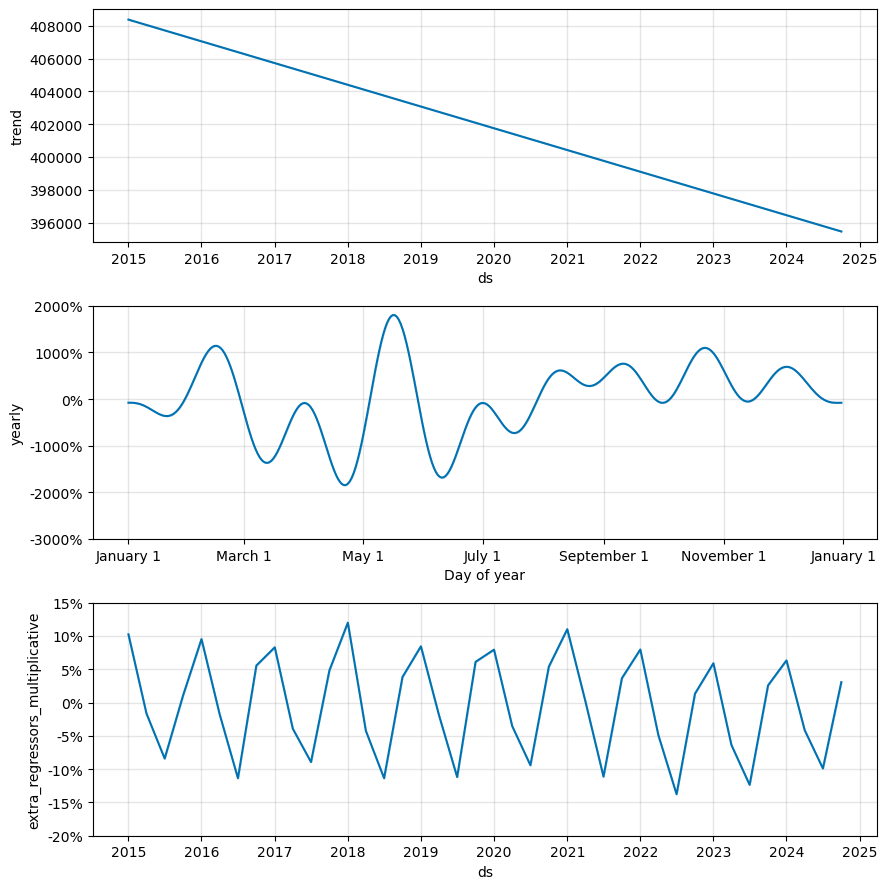

In [62]:
df_forecast = model.predict(df_future)
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)
fig = model.plot_components(df_forecast)

In [63]:
forecast_accuracy(df_test, df_forecast)

RMSE: 5419.39
MAPE: 0.10


OK, a MAPE of 10% isn't bad for a start, but let's see how we can refine our predictions further.

3 main refinements identified: 
1. Prophet hyperparameter tuning 
    - Adjust sensitivities of trend and seasonality
2. Adjust for energy crisis
    - The energy crisis which caused a spike in gas prices from 2022 may have caused a structural shift in domestic consumption behaviour. Existing gas price levels have yet to return to long-term historical averages.
    - Hence, I will treat the post-energy crisis period as a one-off holiday feature     
    - The effect of gas prices on gas demand is likely different post-energy crisis. Therefore I will add an interaction term (price x energy_crisis)
3. Setup lag features for external regressors
    - Demand may have delayed responses to external variables, I suspect this is the case for domestic prices       

In [64]:
# Set a one step lag for domestic prices and backfill for any NaN values
df['domestic_price_lag'] = df['domestic_price'].shift(1)
df['domestic_price_lag'] = df['domestic_price_lag'].bfill()

# Treat the pre/ post-energy crisis period as a binary indicator
df['crisis'] = (df['ds'] >= '2022-01-01').astype(int)

# Add an interaction term for domestic prices and the energy crisis
df['domestic_price_interaction'] = df['domestic_price_lag'] * df['crisis']

# Scale new regressors
df[['domestic_price_lag_scaled','crisis_scaled','domestic_price_interaction_scaled']] = scaler.fit_transform(df[['domestic_price_lag','crisis','domestic_price_interaction']])

#Split training set/ test set
df_train, df_test = split_train_test_set(df, '2015-01-01', '2023-01-01')

#Setup model
model = Prophet(
    growth='linear',
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01,  
    seasonality_prior_scale=5
    )
model.add_regressor('temperature_scaled', mode='multiplicative')
model.add_regressor('domestic_price_lag_scaled', mode='multiplicative')
model.add_regressor('crisis_scaled', mode='multiplicative')
model.add_regressor('domestic_price_interaction_scaled', mode='multiplicative')

#Fit model to training data
model.fit(df_train)


23:03:34 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing


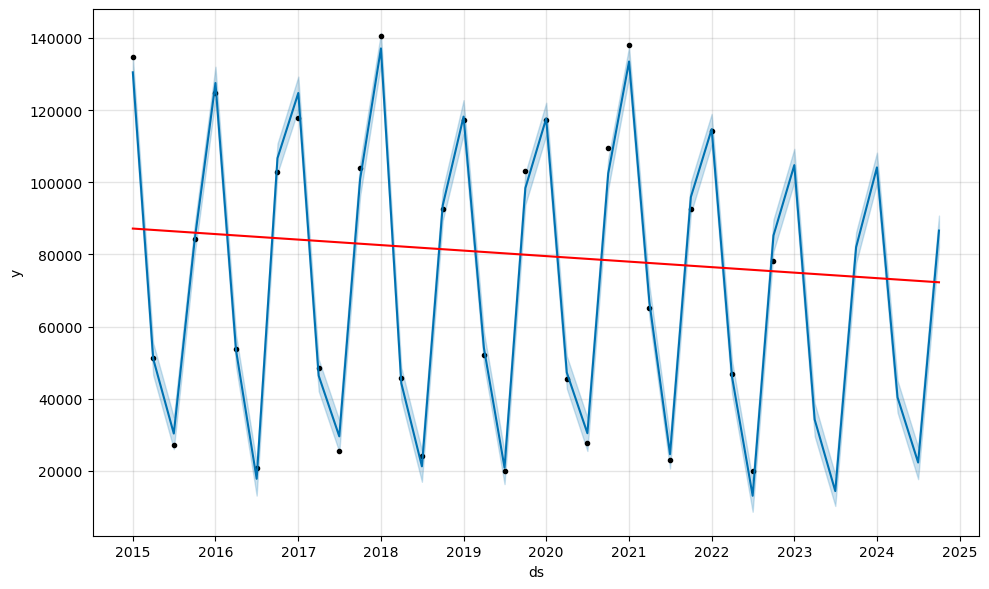

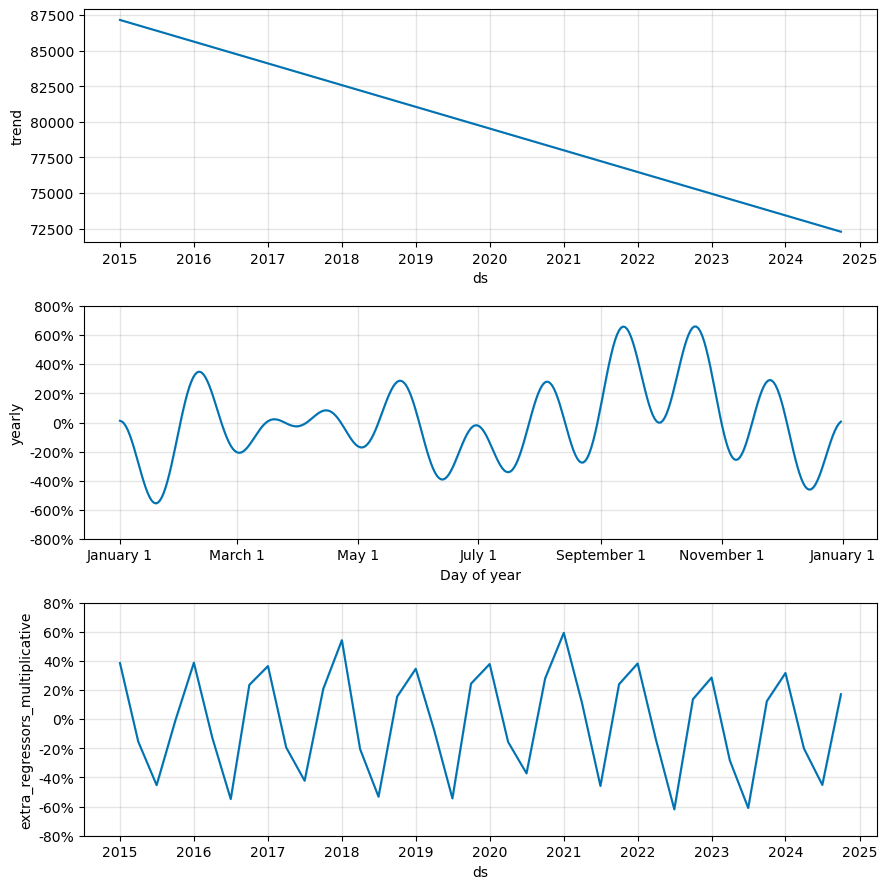

In [65]:
df_future = model.make_future_dataframe(periods=len(df_test), freq='QS')
df_future = pd.merge(df_future, df, on='ds')

df_forecast = model.predict(df_future)
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)
fig = model.plot_components(df_forecast)

In [66]:
forecast_accuracy(df_test, df_forecast)

RMSE: 2401.19
MAPE: 0.05


Results improved, MAPE cut down from 10% to 5%. 

### Modelling Non-domestic Gas Demand
Same methodology as above, now using industrial gas prices as a predictor variable instead.

In [ ]:
df = df.rename(columns={'non_domestic':'y', 'y':'domestic'})

# Set a one step lag for industrial prices and backfill for any NaN values
df['industrial_price_lag'] = df['industrial_price'].shift(1)
df['industrial_price_lag'] = df['industrial_price_lag'].bfill()

# Add an interaction term for industrial prices and the energy crisis
df['industrial_price_interaction'] = df['industrial_price_lag'] * df['crisis']

# Scale new regressors
df[['industrial_price_lag_scaled','industrial_price_interaction_scaled']] = scaler.fit_transform(df[['industrial_price_lag','industrial_price_interaction']])

#Split training set/ test set
df_train, df_test = split_train_test_set(df, '2015-01-01', '2023-01-01')

#Setup model
model = Prophet(
    growth='linear',
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,  
    seasonality_prior_scale=10
    )
model.add_regressor('temperature_scaled', mode='multiplicative')
model.add_regressor('industrial_price_lag_scaled', mode='multiplicative')
model.add_regressor('crisis_scaled', mode='multiplicative')
model.add_regressor('industrial_price_lag_scaled', mode='multiplicative')

#Fit model to training data
model.fit(df_train)


23:03:35 - cmdstanpy - INFO - Chain [1] start processing
23:03:35 - cmdstanpy - INFO - Chain [1] done processing


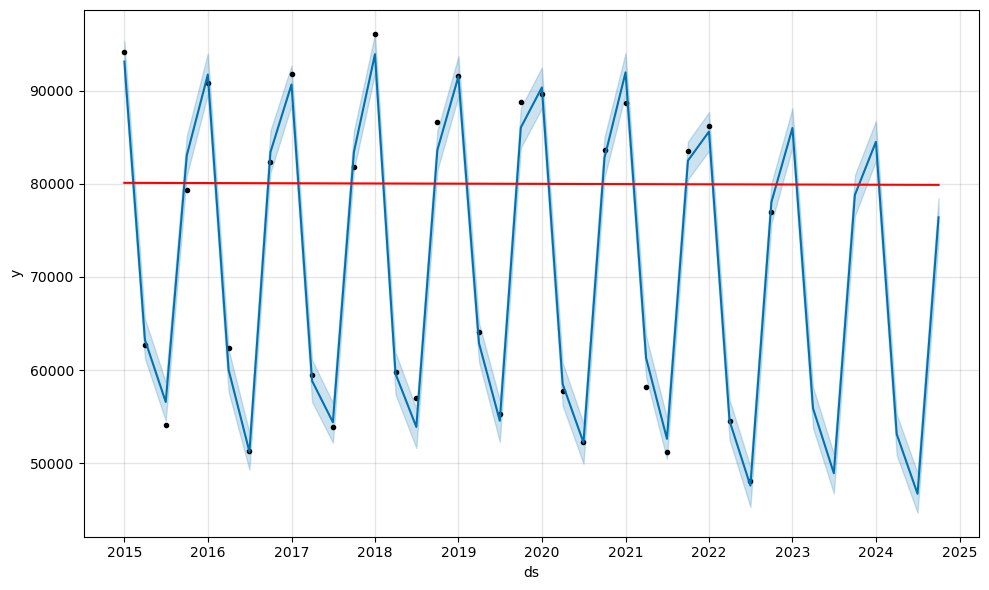

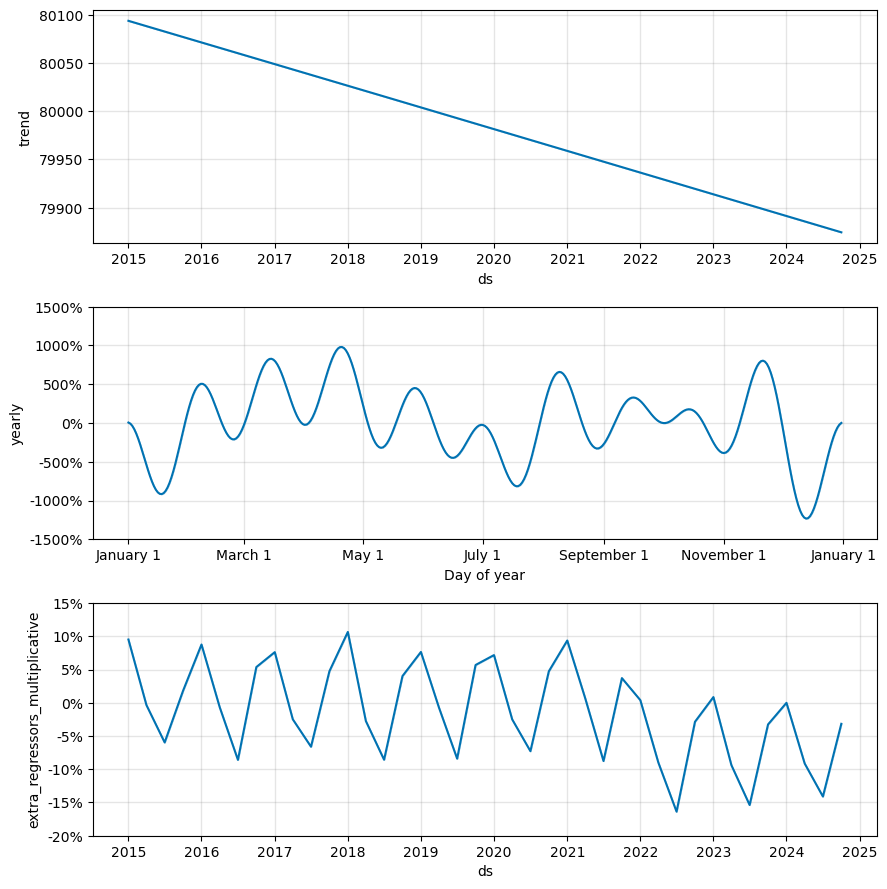

In [68]:
df_future = model.make_future_dataframe(periods=len(df_test), freq='QS')
df_future = pd.merge(df_future, df, on='ds')

df_forecast = model.predict(df_future)
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)
fig = model.plot_components(df_forecast)

In [69]:
forecast_accuracy(df_test, df_forecast)

RMSE: 3281.53
MAPE: 0.04
